# Premier League team analysis (2015/2016)

This script will look at the following:
- Team ball movememnt map.
- Team shot map.
- Goal frequency plot
- xG plot
- xT plot

The goal is to see if we can see visible differences between the top 4 teams and 4 mid table clubs. We want to see if there is something visible that is missing from middle clubs that are visible in top clubs. Perhaps the way that the ball is moved, where shots take place, etc..

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
#opening data
#used for plots
from mplsoccer import Pitch
from mplsoccer import VerticalPitch
from scipy.stats import binned_statistic_2d
from statsbombpy import sb

# pd.options.mode.chained_assignment = None
# warnings.filterwarnings('ignore')

In [2]:
# list of callable functions
functions = [func for func in dir(sb) if callable(getattr(sb, func))]
functions

['Pool',
 'Union',
 '_360_frames',
 'competition_events',
 'competition_frames',
 'competitions',
 'events',
 'filter_and_group_events',
 'frames',
 'lineups',
 'matches',
 'merge_events_and_frames',
 'partial',
 'player_match_stats',
 'player_season_stats',
 'reduce_events',
 'team_season_stats']

In [3]:
comps = sb.competitions()

In [32]:
prem_matches = sb.matches(competition_id=2, season_id=27)

# team_name = ['Inter Milan', 'Juventus', 'Napoli', 'AS Roma', 'Lazio', 'Genoa', 'Fiorentina', 'Empoli']
team_name = 'Arsenal'
team = prem_matches[(prem_matches['home_team'] == team_name) | (prem_matches['away_team'] == team_name)]


In [39]:
# concatenate all match events together to form one dataset
team_matchids = team['match_id']

team_events = pd.DataFrame()
for match in team_matchids:
    
    prem_events = sb.events(match_id=match)

    # if it's the first match, initiate the empty dataframe
    if (match==team_matchids.iloc[0]):
        print('first match: ', match)
        team_events = prem_events
        
    else:
        team_events = pd.concat([team_events, prem_events])
        print(str(match) + ': ' + str(len(team_events)))

first match:  3754041
3753983: 7488
3754038: 11264
3753999: 14935
3754117: 18388
3754174: 21911
3754171: 25673
3754126: 29444
3754160: 32933
3754217: 36665
3754205: 40632
3754296: 44491
3754301: 47994
3754309: 51322
3754240: 54821
3754265: 58282
3754312: 62059
3754129: 66149
3754173: 70192
3753976: 74131
3753980: 78018
3753990: 81577
3754009: 85590
3754069: 89179
3754111: 92920
3754118: 96765
3754184: 100497
3754201: 104018
3754202: 107550
3754239: 111059
3754241: 114571
3754253: 118664
3754261: 122451
3754284: 126272
3754305: 129800
3754314: 133352
3754318: 136774
3754141: 140338


In [40]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(team_events):
    # filter on only ball moving variables (dribble, pass, carry)
    # team_events = team_events[(team_events['type'].str.contains("Pass", regex=False, na=False)) | (team_events['type'] == "Dribble") | (team_events['type'].str.contains("Carry", regex=False, na=False))]
    
    # don't include dribble for now as there is no end location data
    team_events = team_events[(team_events['type'].str.contains("Pass", regex=False, na=False)) | (team_events['type'].str.contains("Carry", regex=False, na=False))]
    
    # filter on only successful passes
    team_events = team_events[team_events['pass_outcome'].isna()]
    # separate x and y coordinates
    team_events["x"] = team_events.location.apply(lambda cell: (cell[0]))
    team_events["y"] = team_events.location.apply(lambda cell: (cell[1]))

    
    team_events["pass_end_x"] = team_events.pass_end_location.apply(lambda cell: (cell[0]) if isinstance(cell, (list, tuple)) else None)
    team_events["pass_end_y"] = team_events.pass_end_location.apply(lambda cell: (cell[1]) if isinstance(cell, (list, tuple)) else None) 

    team_events["carry_end_x"] = team_events.carry_end_location.apply(lambda cell: (cell[0]) if isinstance(cell, (list, tuple)) else None)
    team_events["carry_end_y"] = team_events.carry_end_location.apply(lambda cell: (cell[1]) if isinstance(cell, (list, tuple)) else None)


    return team_events

team_events_clean = clean_data(team_events.copy())
team_events_clean.head()

,ball_receipt_outcome,ball_recovery_recovery_failure,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,...,goalkeeper_lost_out,clearance_other,shot_redirect,shot_follows_dribble,x,y,pass_end_x,pass_end_y,carry_end_x,carry_end_y
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,60.0,40.0,59.7,42.8,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,59.0,42.6,48.2,30.9,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,51.9,37.2,64.6,38.7,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,46.2,57.8,51.0,51.5,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,51.6,48.7,51.0,6.4,NaN,NaN


In [41]:
team_events_clean[['player', 'type', 'location', 'x', 'y', 'pass_end_location', 'pass_end_x', 'pass_end_y', 'carry_end_location', 'carry_end_x', 'carry_end_y']]
team_events_clean.type.unique()

array(['Pass', 'Carry'], dtype=object)

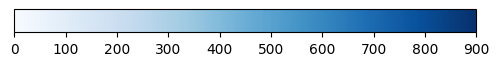

In [42]:
# plotting only the colour legend

# Create a figure for the color legend
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust figsize as needed

# fig.patch.set_facecolor('lightgrey')  # Set the background color of the figure
# ax.set_facecolor('lightgrey')         # Set the background color of the axis

# Create a dummy ScalarMappable with a colormap and norm for the color bar
cmap = plt.cm.Blues
norm = plt.Normalize(vmin=0, vmax=900)

# Create the color bar without an associated plot
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal')

# Optionally set the color bar label
# cbar.set_label('Movement Count', fontsize=12)

# Remove the axis (we only want the color legend)
ax.remove()

# Show the color legend
plt.show()

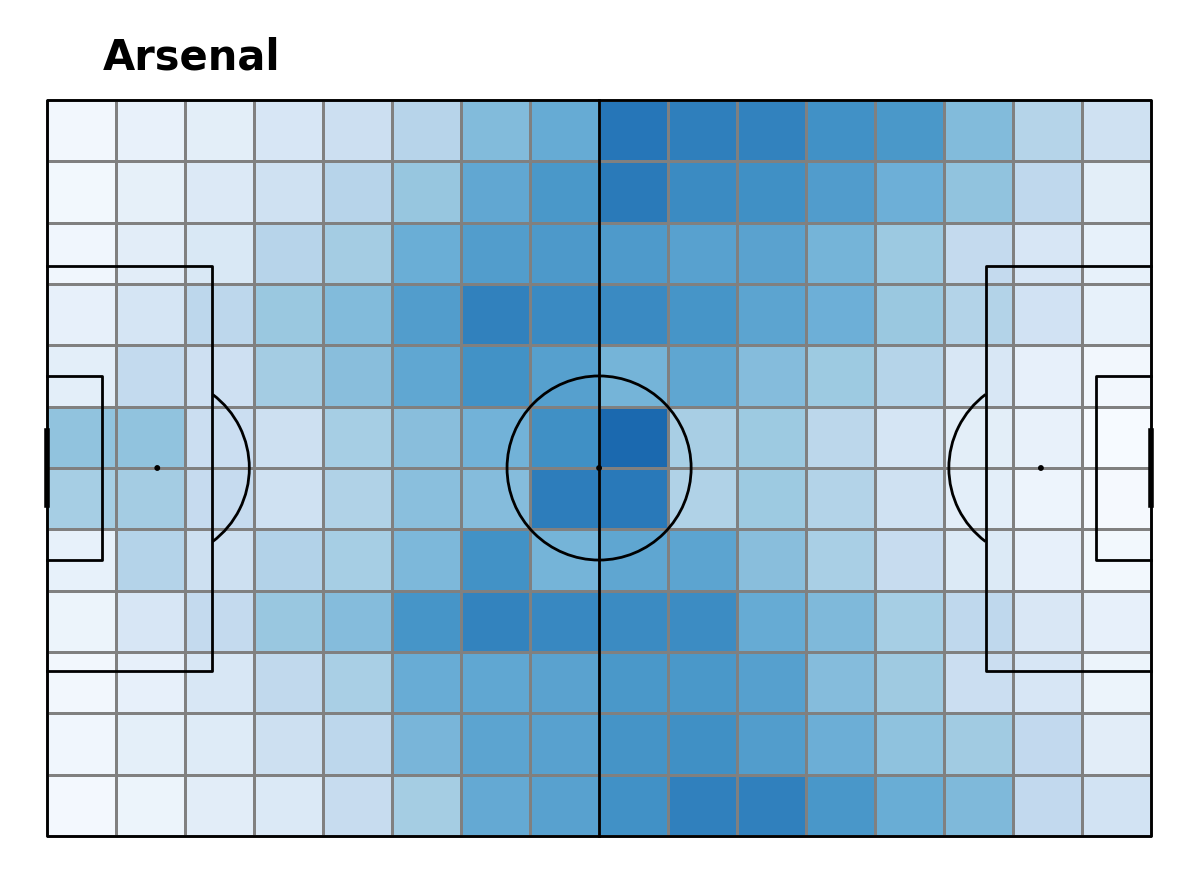

In [43]:
# show 2D histogram of single club's moving data

pitch = Pitch(line_color='black', pitch_type='statsbomb', line_zorder = 2)
move = pitch.bin_statistic(team_events_clean.x, team_events_clean.y, statistic='count', bins=(16, 12), normalize=False) # separate pitch into these bins and visualise counts of moves

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0, title_space=0)


# pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
pcm = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'], vmin=0, vmax=900)
#legend to our plot
# ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
# cbar = plt.colorbar(pcm, cax=ax_cbar)
# fig.suptitle('Moving Actions Heatmap', fontsize = 30)
# Add title and subtitle
fig.text(0.1, 0.95, team_name, fontsize=30, ha='left', va='top', weight='bold')
plt.show()
#get the array
move_count = move["statistic"]

# Save image
# Construct the filename
filename = f"plots/movement map/{team_name}_movement_map.png"
# Save the figure
fig.savefig(filename, bbox_inches='tight')


In [44]:
# get the shot data
def shot_data(team_data):
    shot_df = team_data[team_data['type']=='Shot']
    # separate x and y coordinates
    shot_df["x"] = shot_df.location.apply(lambda cell: (cell[0]))
    shot_df["y"] = shot_df.location.apply(lambda cell: (cell[1]))

    return shot_df

shot_df = shot_data(team_events.copy())

C:\Users\GEdwards\AppData\Local\Temp\ipykernel_24056\3656607712.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_df["x"] = shot_df.location.apply(lambda cell: (cell[0]))
C:\Users\GEdwards\AppData\Local\Temp\ipykernel_24056\3656607712.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_df["y"] = shot_df.location.apply(lambda cell: (cell[1]))


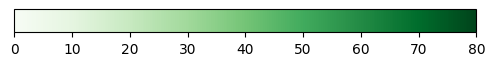

In [45]:
# plotting only the colour legend for shot frequency

# Create a figure for the color legend
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust figsize as needed

# fig.patch.set_facecolor('lightgrey')  # Set the background color of the figure
# ax.set_facecolor('lightgrey')         # Set the background color of the axis

# Create a dummy ScalarMappable with a colormap and norm for the color bar
cmap = plt.cm.Greens
norm = plt.Normalize(vmin=0, vmax=80)

# Create the color bar without an associated plot
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal')

# Optionally set the color bar label
# cbar.set_label('Movement Count', fontsize=12)

# Remove the axis (we only want the color legend)
ax.remove()

# Show the color legend
plt.show()

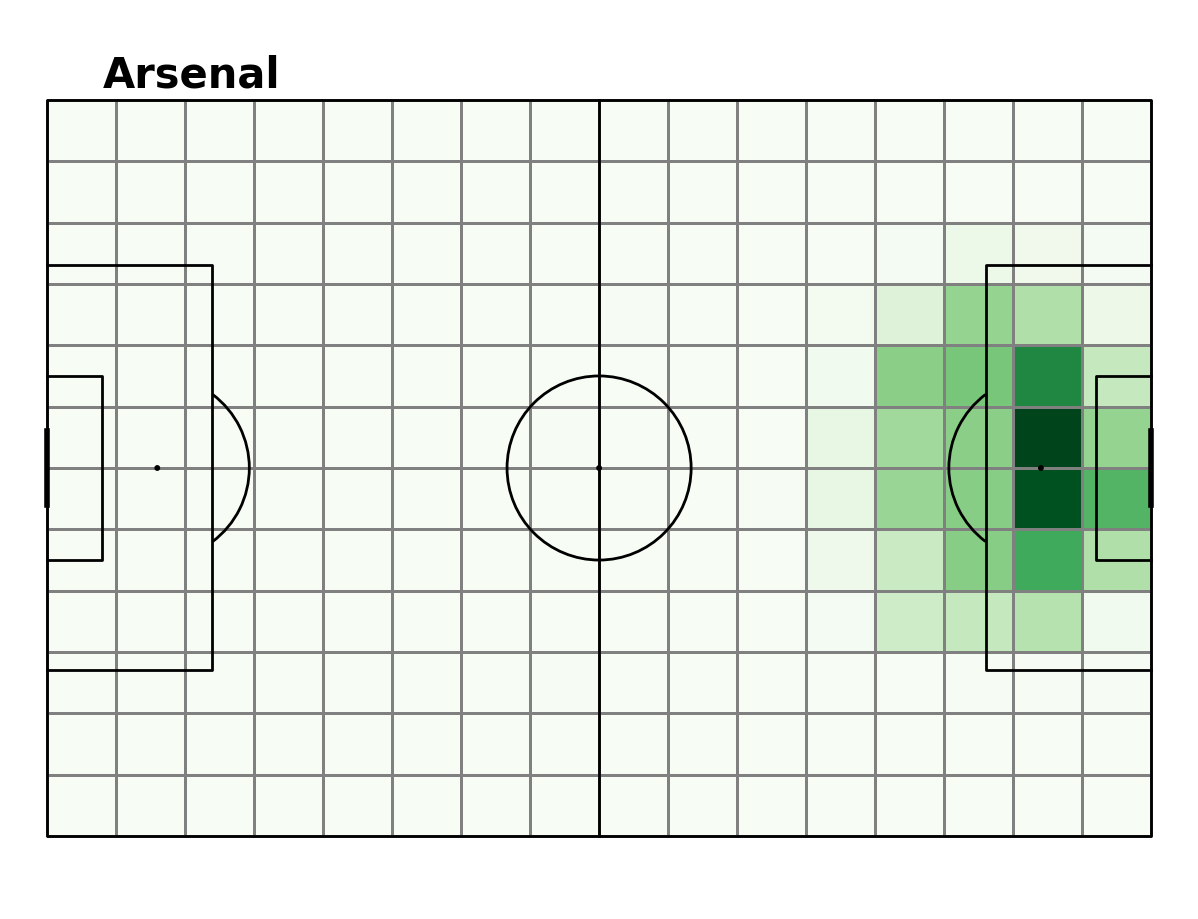

In [46]:
# shot frequency per pitch zone plot

pitch = Pitch(line_color='black', pitch_type='statsbomb', line_zorder = 2)
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False) # separate pitch into these bins and visualise counts of shots

# plot heatmap of where shots come from based on shot count
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
# ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
# cbar = plt.colorbar(pcm, cax=ax_cbar)
# fig.suptitle('Shots 2D histogram', fontsize = 30)
fig.text(0.1, 0.95, team_name, fontsize=30, ha='left', va='top', weight='bold')
plt.show()

shot_count = shot["statistic"]

# Save image
# Construct the filename
filename = f"plots/shot frequency/{team_name}_shot_freq.png"
# Save the figure
fig.savefig(filename, bbox_inches='tight')

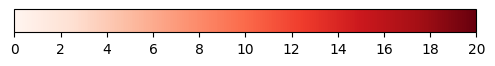

In [48]:
# plotting only the colour legend for goal frequency

# Create a figure for the color legend
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust figsize as needed

# fig.patch.set_facecolor('lightgrey')  # Set the background color of the figure
# ax.set_facecolor('lightgrey')         # Set the background color of the axis

# Create a dummy ScalarMappable with a colormap and norm for the color bar
cmap = plt.cm.Reds
norm = plt.Normalize(vmin=0, vmax=20)

# Create the color bar without an associated plot
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal')

# Set the ticks to be integers only
cbar.set_ticks(np.arange(0, 21, 2))  # Ticks from 0 to 20 with a step of 1

# Remove the axis (we only want the color legend)
ax.remove()

# Show the color legend
plt.show()

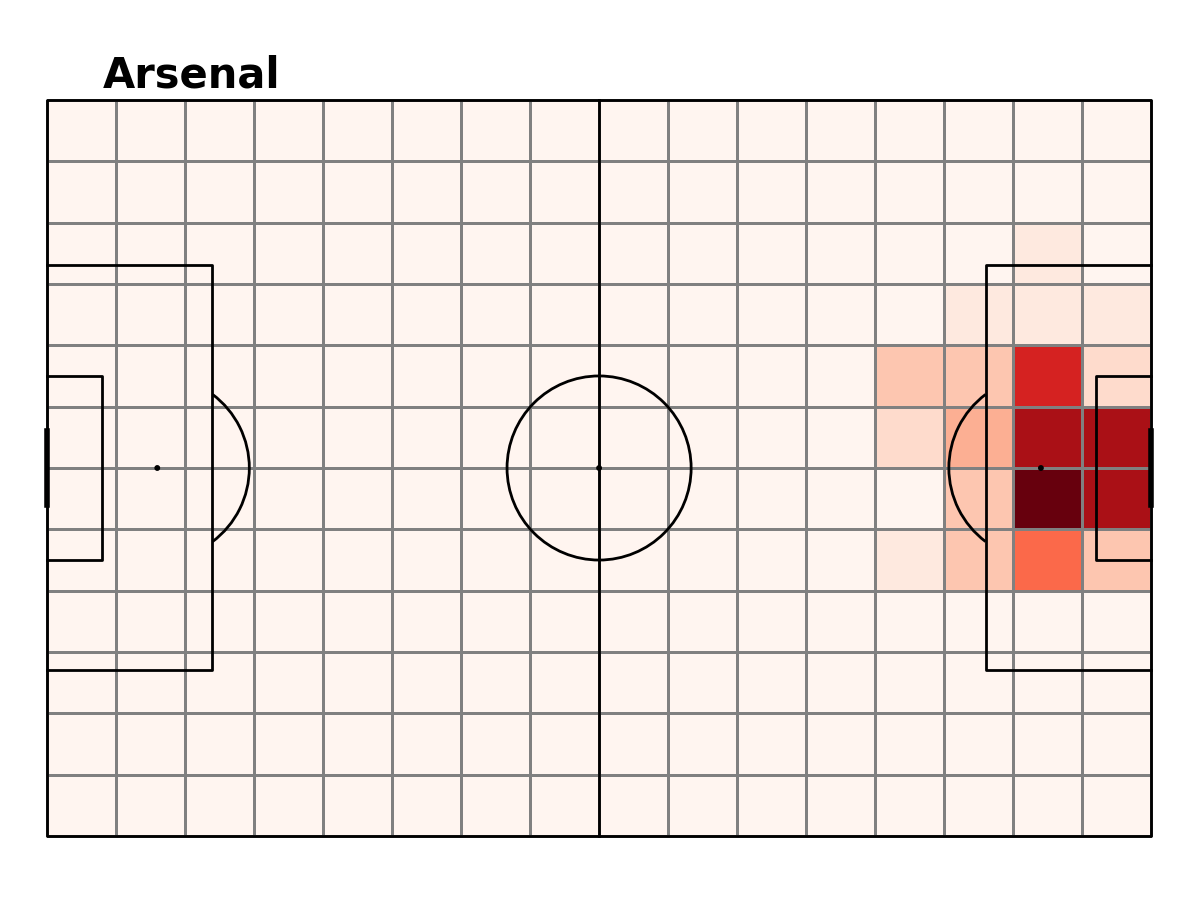

In [49]:
# plot of goal frequency per segment
goal_df  = shot_df.loc[shot_df.apply(lambda x: 'Goal' in x.shot_outcome, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
# ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
# cbar = plt.colorbar(pcm, cax=ax_cbar)
# fig.suptitle('Goal 2D histogram', fontsize = 30)
fig.text(0.1, 0.95, team_name, fontsize=30, ha='left', va='top', weight='bold')
plt.show()

# Save image
# Construct the filename
filename = f"plots/goal frequency/{team_name}_goal_freq.png"
# Save the figure
fig.savefig(filename, bbox_inches='tight')

In [50]:
# visualising the move probability
move_probability = move_count/(move_count+shot_count)
move["statistic"] = move_probability
#plotting it
# fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
#                      endnote_height=0.04, title_space=0, endnote_space=0)


# pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
# #legend to our plot
# ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
# cbar = plt.colorbar(pcm, cax=ax_cbar)
# fig.suptitle('Move probability 2D histogram', fontsize = 30)
# plt.show()

In [51]:
# shot probability visualisation
shot_probability = shot_count/(move_count+shot_count)
shot["statistic"] = shot_probability

#plotting it
# fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
#                      endnote_height=0.04, title_space=0, endnote_space=0)

# pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
# #legend to our plot
# ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
# cbar = plt.colorbar(pcm, cax=ax_cbar)
# fig.suptitle('Shot probability 2D histogram', fontsize = 30)
# plt.show()



In [16]:
# goal probability

# goal_probability = goal_count / shot_count
# goal_probability[np.isnan(goal_probability)] = 0

#plotting it
# fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
#                      endnote_height=0.04, title_space=0, endnote_space=0)
# goal["statistic"] = goal_probability
# pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
# #legend to our plot
# ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
# cbar = plt.colorbar(pcm, cax=ax_cbar)
# fig.suptitle('Goal probability 2D histogram', fontsize = 30)
# plt.show()

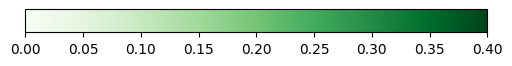

In [52]:
# legend for xG plots

# Create a figure for the color legend
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust figsize as needed

# fig.patch.set_facecolor('lightgrey')  # Set the background color of the figure
# ax.set_facecolor('lightgrey')         # Set the background color of the axis

# Create a dummy ScalarMappable with a colormap and norm for the color bar
cmap = plt.cm.Greens
norm = plt.Normalize(vmin=0, vmax=0.4)

# Create the color bar without an associated plot
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal')

# Set the ticks to be integers only
# cbar.set_ticks(np.arange(0, 21, 2))  # Ticks from 0 to 20 with a step of 1

# Remove the axis (we only want the color legend)
ax.remove()

# Show the color legend
plt.show()

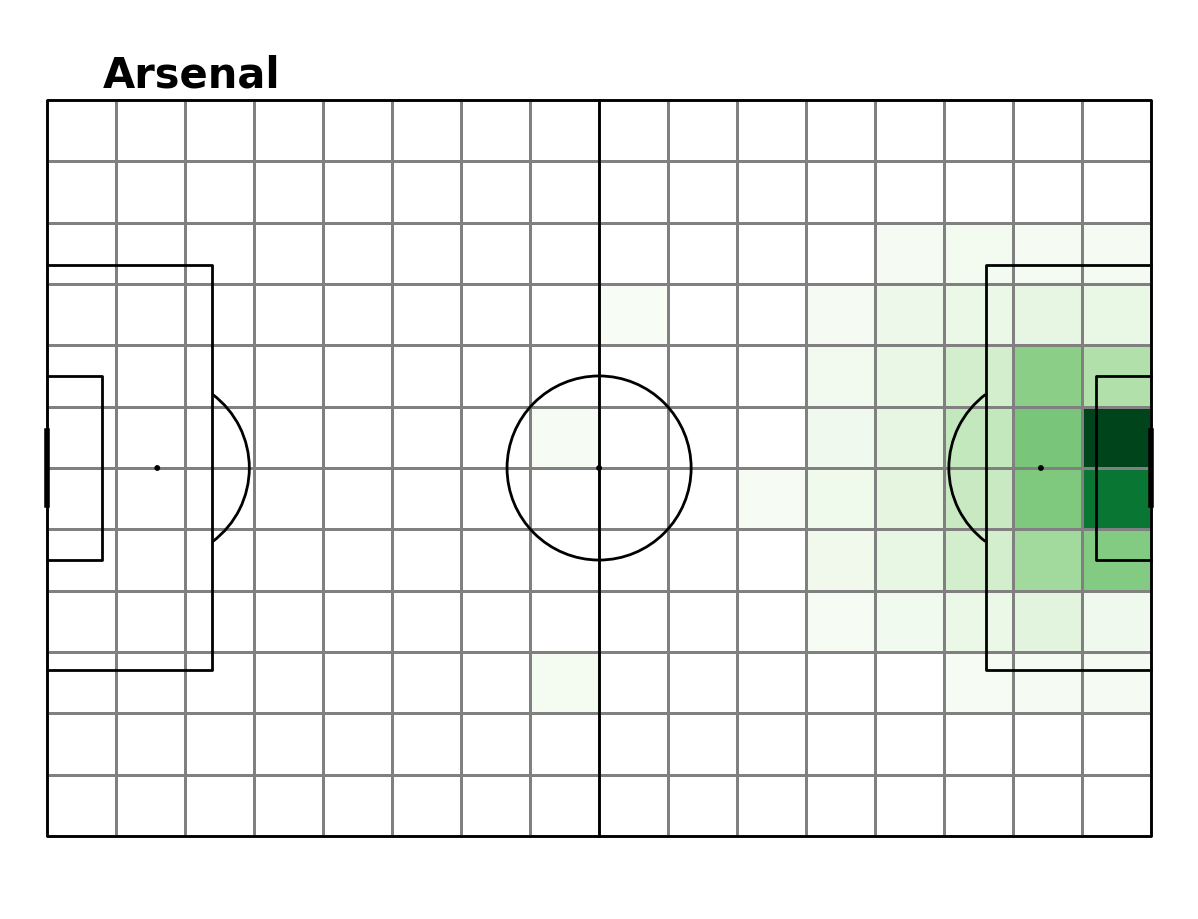

In [53]:
# create plot where you visualise average xG in each block
pitch = Pitch(line_color='black', pitch_type='statsbomb', line_zorder = 2)
shot_xg = pitch.bin_statistic(shot_df.x, shot_df.y, values=shot_df.shot_statsbomb_xg, statistic='mean', bins=(16, 12), normalize=False)

# plot heatmap of where shots come from based on shot count
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot_xg, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
# ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
# cbar = plt.colorbar(pcm, cax=ax_cbar)
# fig.suptitle('xG 2D histogram', fontsize = 30)
fig.text(0.1, 0.95, team_name, fontsize=30, ha='left', va='top', weight='bold')
plt.show()

shot_xg_grid = shot_xg["statistic"]
shot_xg_grid[np.isnan(shot_xg_grid)] = 0

# Save image
# Construct the filename
filename = f"plots/xG/{team_name}_xg.png"
# Save the figure
fig.savefig(filename, bbox_inches='tight')

#### Transition Matrix

For each of 192 sectors we need to calculate a transition matrix - a matrix of probabilities going from one zone to another one given that the ball was moved. First, we create another columns in the move_df with the bin on the histogram that the event started and ended in. Then, we group the data by starting sector and count starts from each of them. As the next step, for each of the sectors we calculate the probability of transfering the ball from it to all 192 sectors on the pitch. given that the ball was moved. We do it as the division of events that went to the end sector by all events that started in the starting sector. As the last step, we vizualize the transition matrix for the sector in the bottom left corner of the pitch.

In [54]:
# create move probability plot for each segment of the pitch (edit to use plotly and try a dynamic visualisation)

# Helper function to get the value if not NA, otherwise the alternative
def get_value_or_alternative(primary, alternative):
    return primary if not np.isnan(primary).all() else alternative

#### NB fill in missing sectors from start_sector. Some teams have had no action in specific sectors

#move start index - using the same function as mplsoccer, it should work
team_events_clean["start_sector"] = team_events_clean.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 120], [0, 80]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

all_sectors = [(i+1, j+1) for i in range(16) for j in range(12)]
current_sectors = team_events_clean['start_sector']
missing_sectors = set(all_sectors) - set(current_sectors)

for i in list(missing_sectors):
    team_events_clean = pd.concat([team_events_clean, pd.DataFrame({"start_sector":[i]})], ignore_index=True)


#move end index
team_events_clean["end_sector"] = team_events_clean.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(get_value_or_alternative(np.ravel(row.pass_end_x), np.ravel(row.carry_end_x)),
                                                                                                               get_value_or_alternative(np.ravel(row.pass_end_y), np.ravel(row.carry_end_y)),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 120], [0, 80]],
                                                               expand_binnumbers=True)[3]]), axis = 1) # produces bin (17,13) if pass_end and carry_end are nas this is due to no end value for dribbles


#df with summed events from each index
df_count_starts = team_events_clean.groupby(["start_sector"])["index"].count().reset_index() # number of actions that took place in each sector
df_count_starts.rename(columns = {'index':'count_starts'}, inplace=True)
# print(df_count_starts)

transition_matrices = []
for i, row in df_count_starts.iterrows():
    
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    #get all events that started in this sector
    this_sector = team_events_clean.loc[team_events_clean["start_sector"] == start_sector]
    # print(start_sector[0])

    if (this_sector.start_sector.values[0] not in list(missing_sectors)):
        if (start_sector[0] != 17):
            df_cound_ends = this_sector.groupby(["end_sector"])["index"].count().reset_index()
            df_cound_ends.rename(columns = {'index':'count_ends'}, inplace=True)
            # print(row)
            # print(df_cound_ends)
            T_matrix = np.zeros((12, 16))
            for j, row2 in df_cound_ends.iterrows():
                
                end_sector = row2["end_sector"]
                value = row2["count_ends"]

                # T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value

                # some rows still result in (17,13)
                T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value

            T_matrix = T_matrix / count_starts
            transition_matrices.append(T_matrix)
        
    else:
        T_matrix = np.zeros((12, 16))
        transition_matrices.append(T_matrix)

len(transition_matrices)

192

In [20]:
#let's plot it for the zone [1,1] - left down corner
# fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
#                      endnote_height=0.04, title_space=0, endnote_space=0)

# # Change the index here to change the zone.
# goal["statistic"] = transition_matrices[152]
# pcm  = pitch.heatmap(goal, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
# #legend to our plot
# ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
# cbar = plt.colorbar(pcm, cax=ax_cbar)
# fig.suptitle('Transition probability for one of the middle zones', fontsize = 30)
# plt.show()

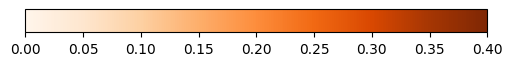

In [55]:
# legend for xT plots

# Create a figure for the color legend
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust figsize as needed

# fig.patch.set_facecolor('lightgrey')  # Set the background color of the figure
# ax.set_facecolor('lightgrey')         # Set the background color of the axis

# Create a dummy ScalarMappable with a colormap and norm for the color bar
cmap = plt.cm.Oranges
norm = plt.Normalize(vmin=0, vmax=0.4)

# Create the color bar without an associated plot
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal')

# Set the ticks to be integers only
# cbar.set_ticks(np.arange(0, 21, 2))  # Ticks from 0 to 20 with a step of 1

# Remove the axis (we only want the color legend)
ax.remove()

# Show the color legend
plt.show()

Expected Threat matrix after 5 moves


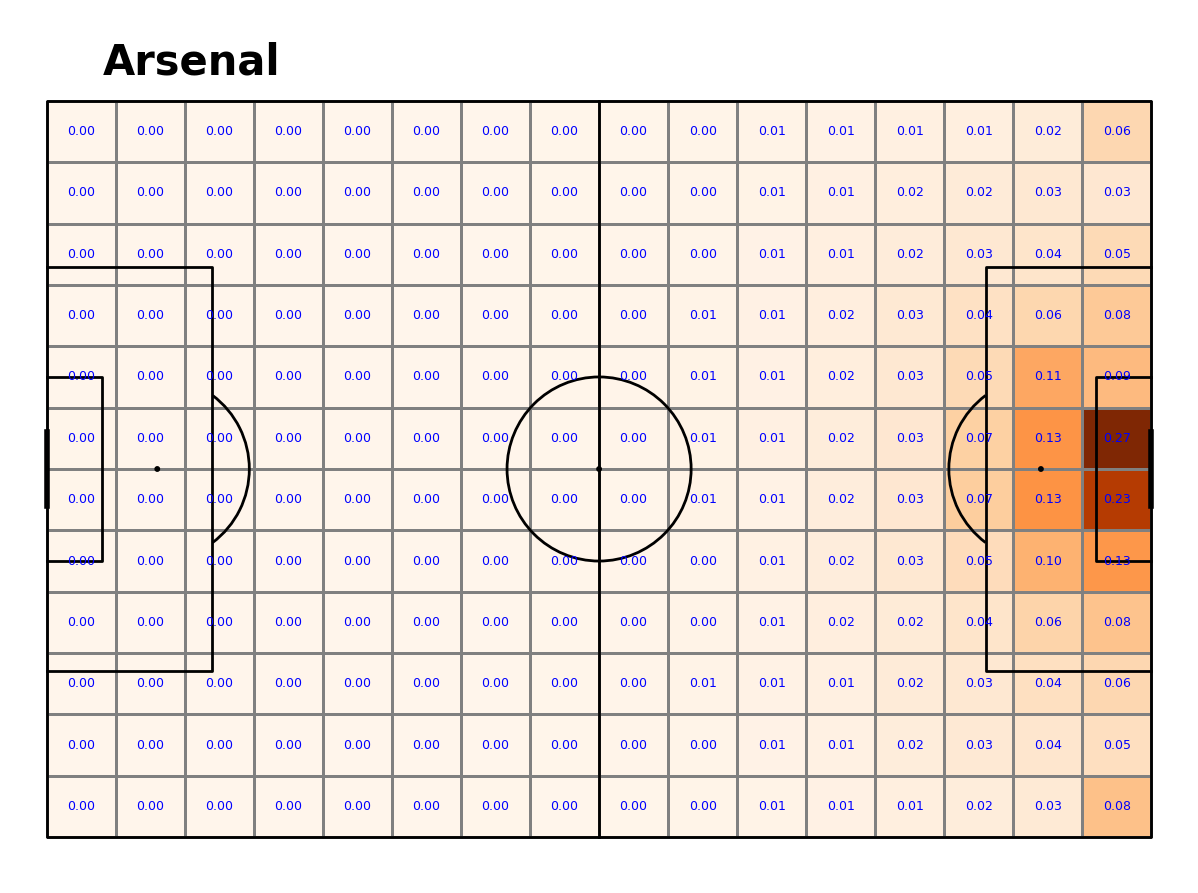

In [56]:
transition_matrices_array = np.array(transition_matrices)

xT = np.zeros((12, 16))
for i in range(5):
    shoot_expected_payoff = shot_xg_grid*shot_probability
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    if i == 4:
        #let's plot it!
        fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                        endnote_height=0.01, title_space=0, endnote_space=0)
        goal["statistic"] = xT
        pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
        labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                                ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
        #legend to our plot
        # ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
        # cbar = plt.colorbar(pcm, cax=ax_cbar)
        txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
        print(txt)
        # fig.suptitle(txt, fontsize = 30)
        fig.text(0.1, 0.95, team_name, fontsize=30, ha='left', va='top', weight='bold')
        plt.show()

        # Save image
        # Construct the filename
        filename = f"plots/xT/{team_name}_xt.png"
        # Save the figure
        fig.savefig(filename, bbox_inches='tight')

In [57]:
goal["statistic"]

array([[1.22864434e-04, 1.53993958e-04, 1.88009372e-04, 3.11256835e-04,
        3.14493153e-04, 7.98694421e-04, 9.48561772e-04, 1.47960812e-03,
        1.60628443e-03, 3.55071489e-03, 5.30780197e-03, 8.24114013e-03,
        1.22571532e-02, 1.49203810e-02, 2.25618316e-02, 5.75568624e-02],
       [1.60208555e-04, 2.22973611e-04, 2.74215429e-04, 2.92259591e-04,
        7.92376787e-04, 5.89032912e-04, 9.49792166e-04, 1.48894132e-03,
        2.09604140e-03, 3.78825366e-03, 6.30058463e-03, 1.13583943e-02,
        1.67213543e-02, 2.35711133e-02, 2.99616828e-02, 3.12241228e-02],
       [1.10509824e-04, 1.55682167e-04, 3.08499556e-04, 3.41954377e-04,
        4.97272686e-04, 4.04656900e-04, 8.32925803e-04, 1.44823427e-03,
        2.52731103e-03, 4.04042652e-03, 7.28963655e-03, 1.31047798e-02,
        2.11892617e-02, 3.07976702e-02, 3.67096255e-02, 5.31224238e-02],
       [2.52434745e-04, 3.96743578e-04, 3.57174052e-04, 6.08781458e-04,
        4.58288124e-04, 5.95962156e-04, 9.50331253e-04, 1.355